In [30]:
import os
import umap
import h5py
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr # Pearson cor
import common.plotting



In [66]:
dataset=h5py.File( "/cours/a23_bin3002-a/cours/TP6/TCGA_BRCA_fpkm_hv_norm_PAM50.h5")


In [73]:

brca_data = dataset["data"][:,:]
labels = np.array(dataset["labels"][:], dtype = str)
samples = np.array(dataset["samples"][:], dtype = str)
genes = np.array(dataset["genes"][:], dtype = str) 


In [74]:
print(f"shape of gene expression data : {brca_data.shape}\nnb of genes in data : {gene_names.shape[0]}\nncols (sample ids) in data :  {sample_ids.shape[0]}\nnb of labels = sample ids : {labels.shape[0]}")

shape of gene expression data : (11802, 1023)
nb of genes in data : 15165
ncols (sample ids) in data :  10346
nb of labels = sample ids : 1023


In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(brca_data.T, labels, test_size = 0.2)

In [76]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, n_neighbors =10, n_epochs = 1000).fit(X_train)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Wed Dec  6 01:31:25 2023 Construct fuzzy simplicial set
Wed Dec  6 01:31:27 2023 Finding Nearest Neighbors
Wed Dec  6 01:31:30 2023 Finished Nearest Neighbor Search
Wed Dec  6 01:31:30 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Wed Dec  6 01:31:33 2023 Finished embedding


In [77]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


In [78]:
# Processing des données
targets = np.unique(labels)
count_df = pd.DataFrame(tpm_data).T
labels_df = pd.DataFrame(labels)

count_df["labels"] = labels

print(count_df["labels"])

0         LumB
1         Her2
2         LumB
3       Normal
4       Normal
         ...  
1018      LumA
1019    Normal
1020    Normal
1021    Normal
1022      LumB
Name: labels, Length: 1023, dtype: object


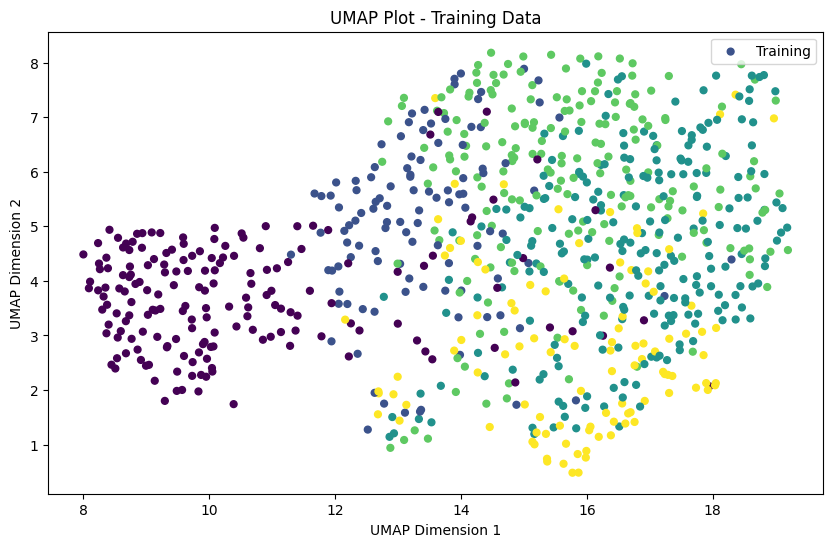

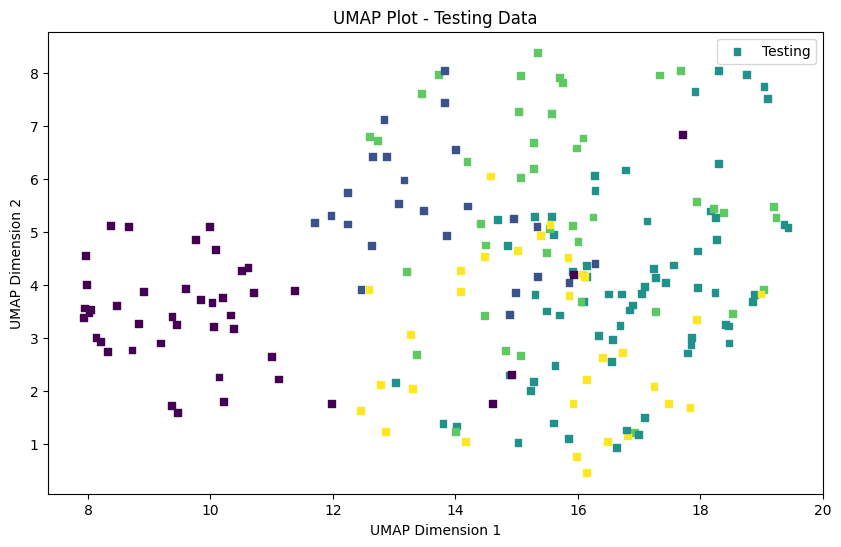

In [112]:
def plot_umap_separate(X_train, X_test, Y_train, Y_test, labels, s=24):
    # Use LabelEncoder to convert labels to integers for color mapping
    label_encoder = LabelEncoder()

    # Plot UMAP embeddings for training data
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=label_encoder.fit_transform(Y_train), cmap='viridis', s=s, label='Training')
    
    # Customize plot
    plt.title('UMAP Plot - Training Data')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    
    # Show the plot
    plt.show()

    # Plot UMAP embeddings for testing data
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test[:, 0], X_test[:, 1], c=label_encoder.transform(Y_test), cmap='viridis', marker='s', s=s, label='Testing')
    
    # Customize plot
    plt.title('UMAP Plot - Testing Data')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage
plot_umap_separate(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s=24)

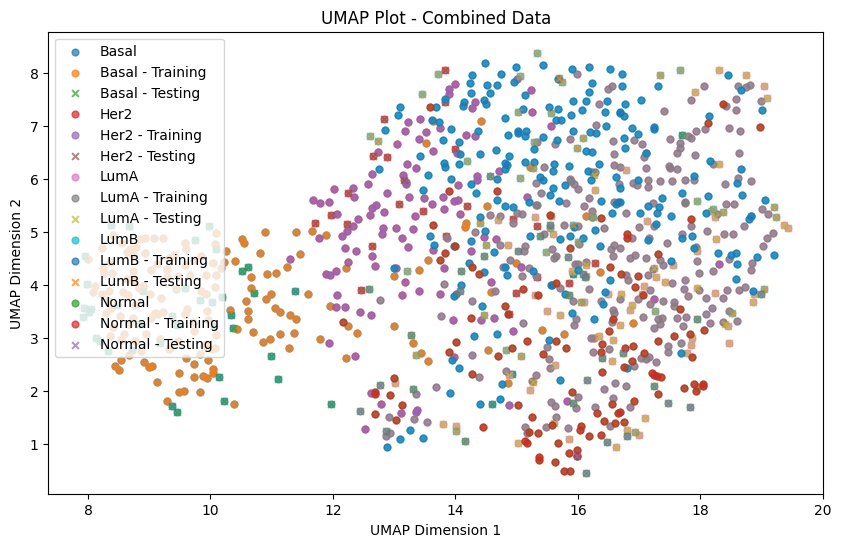

In [117]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def plot_umap_combined_with_legend_and_shapes(X_train, X_test, Y_train, Y_test, labels, s=24):
    # Use LabelEncoder to convert labels to integers for color mapping
    label_encoder = LabelEncoder()

    # Combine training and testing data
    X_combined = np.vstack((X_train, X_test))
    Y_combined = np.concatenate((Y_train, Y_test))

    # Plot UMAP embeddings for combined data
    plt.figure(figsize=(10, 6))
    for label in np.unique(Y_combined):
        indices_combined = Y_combined == label
        indices_train = Y_train == label
        indices_test = Y_test == label
        
        plt.scatter(X_combined[indices_combined, 0], X_combined[indices_combined, 1], s=s, label=f'{label}', alpha=0.7)
        
        if any(indices_train):
            plt.scatter(X_train[indices_train, 0], X_train[indices_train, 1], s=s, label=f'{label} - Training', alpha=0.7, marker='o')
        
        if any(indices_test):
            plt.scatter(X_test[indices_test, 0], X_test[indices_test, 1], s=s, label=f'{label} - Testing', alpha=0.7, marker='x')

    # Customize plot
    plt.title('UMAP Plot - Combined Data')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()

    # Show the plot
    plt.show()

# Example usage
plot_umap_combined_with_legend_and_shapes(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s=24)


In [118]:
import torch
from torch import nn

In [119]:
### fonction d'initialisation du reseau
def auto_encoder(insize, outsize, bnsize, width=100):
    model = nn.Sequential(
    nn.Linear(insize,width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, bnsize), 
    nn.Linear(bnsize, width),
    nn.ReLU(),
    nn.Linear(width, outsize))
    return model, model[0:5]

In [120]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [121]:
mm,encoder  = auto_encoder(insize, insize, 2)
encoder(X_train).shape
mm.parameters()

<generator object Module.parameters at 0x7f9830c7b060>

In [131]:
def train_auto_encoder(insize, bnsize, X_train, X_test, nepochs = 100, printstep=10, wd = 1e-3, lr = 0.0001):
    DNN, encoder = auto_encoder(insize, insize, bnsize )
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr, weight_decay = wd)
    tr_losses, tst_losses, tr_accs, tst_accs = [],[],[],[]
    for i in range(nepochs):
        optimizer.zero_grad() # required
        y_tr_out = DNN(X_train) # feed forward
        y_tst_out = DNN(X_test)
        tr_loss = nn.functional.mse_loss(y_tr_out, X_train) # loss computation
        tst_loss = nn.functional.mse_loss(y_tst_out, X_test) # Softmax -> NLL
        
        tr_acc = pearsonr(y_tr_out.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic # Pearson corr. coeff
        tst_acc = pearsonr(y_tst_out.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic
            
        if i % printstep == 0 or i+1 == nepochs :
            print(f"Loss {i} Train - loss : {round(float(tr_loss),2)} - acc : {round(float(tr_acc),2)} Test acc : {round(tst_acc,2)}")
        tr_loss.backward() # back prop
        optimizer.step() # optimizer update
        [tr_losses.append(float(tr_loss)), tst_losses.append(float(tst_loss)), tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
    return DNN, np.array(tr_losses), np.array(tst_losses), np.array(tr_accs), np.array(tst_accs)


In [132]:
mm, trl, tstl, trc, tstc  = train_auto_encoder(insize, 2, X_train, X_test, nepochs = 200, lr = 5 * 1e-4)


Loss 0 Train - loss : 0.18 - acc : -0.0 Test acc : -0.0
Loss 10 Train - loss : 0.15 - acc : 0.04 Test acc : 0.04
Loss 20 Train - loss : 0.13 - acc : 0.09 Test acc : 0.09
Loss 30 Train - loss : 0.12 - acc : 0.14 Test acc : 0.14
Loss 40 Train - loss : 0.11 - acc : 0.2 Test acc : 0.2
Loss 50 Train - loss : 0.1 - acc : 0.24 Test acc : 0.24
Loss 60 Train - loss : 0.08 - acc : 0.3 Test acc : 0.3
Loss 70 Train - loss : 0.05 - acc : 0.44 Test acc : 0.44
Loss 80 Train - loss : 0.03 - acc : 0.63 Test acc : 0.63
Loss 90 Train - loss : 0.03 - acc : 0.65 Test acc : 0.65
Loss 100 Train - loss : 0.03 - acc : 0.65 Test acc : 0.65
Loss 110 Train - loss : 0.03 - acc : 0.66 Test acc : 0.66
Loss 120 Train - loss : 0.03 - acc : 0.66 Test acc : 0.66
Loss 130 Train - loss : 0.03 - acc : 0.66 Test acc : 0.66
Loss 140 Train - loss : 0.03 - acc : 0.66 Test acc : 0.66
Loss 150 Train - loss : 0.03 - acc : 0.66 Test acc : 0.66
Loss 160 Train - loss : 0.03 - acc : 0.66 Test acc : 0.66
Loss 170 Train - loss : 0.03 -

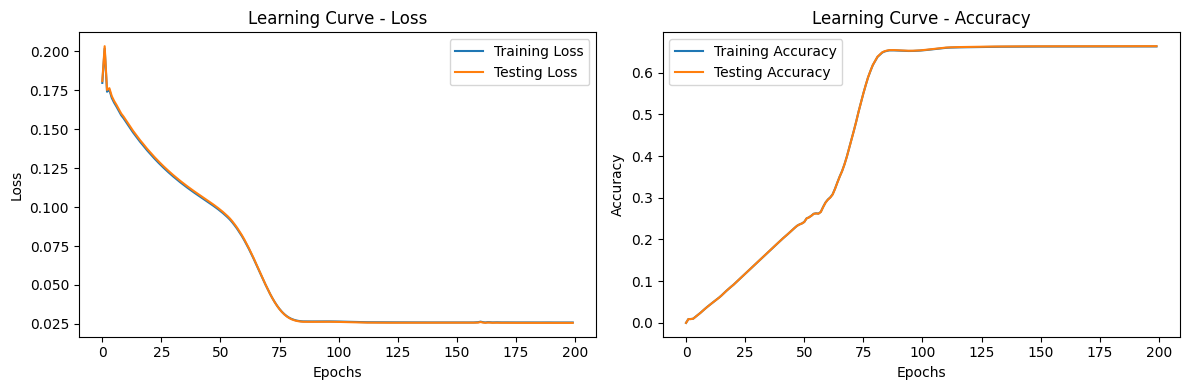

In [133]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test):
    # Assuming trl, tstl, trc, tstc are lists or arrays representing learning curve data

    # Plot training and testing loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(trl, label='Training Loss')
    plt.plot(tstl, label='Testing Loss')
    plt.title('Learning Curve - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and testing accuracy (or any other metric)
    plt.subplot(1, 2, 2)
    plt.plot(trc, label='Training Accuracy')
    plt.plot(tstc, label='Testing Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)

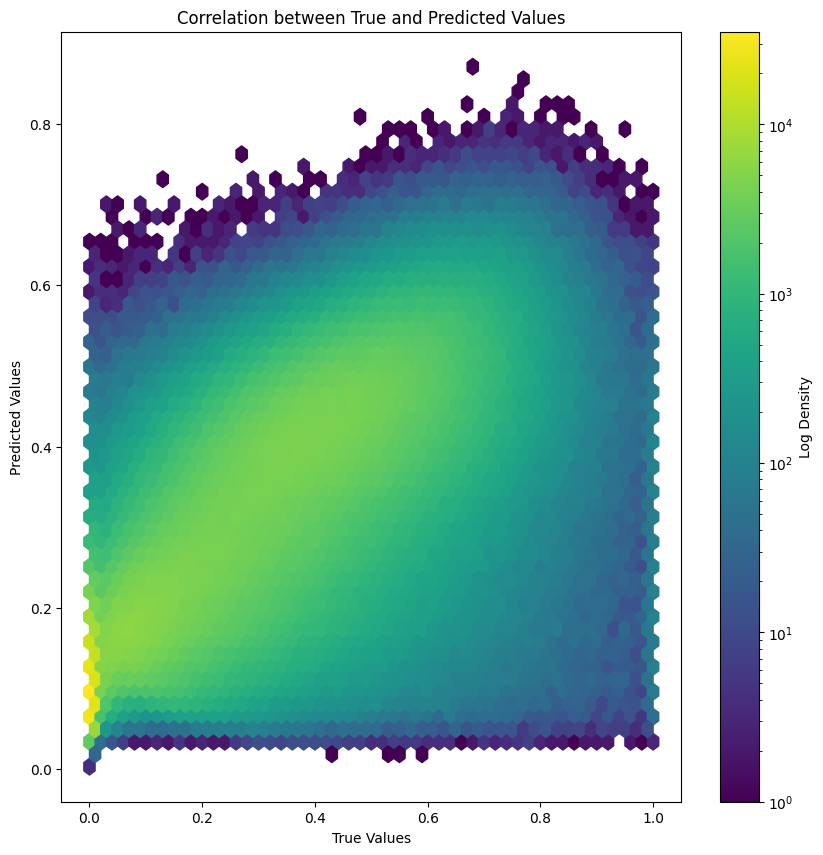

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_hexbin(y_true, y_pred):
    plt.figure(figsize=(10, 10))
    hexbin = plt.hexbin(y_true, y_pred, gridsize=50, cmap='viridis', mincnt=1, bins='log')
    plt.colorbar(label='Log Density')
    plt.title('Correlation between True and Predicted Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()

# Assuming y_true and y_pred are your true and predicted values
y_true = X_test.numpy()  # Replace this with your actual true values
y_pred = mm(X_test).detach().numpy()  # Replace this with your actual predicted values

# Flatten the arrays to 1D
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Example usage
plot_correlation_hexbin(y_true_flat, y_pred_flat)


In [135]:
import torch.nn.functional as F
class VariationalEncoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(insize, width)
        self.linear2 = nn.Linear(width, latent_dims)
        self.linear3 = nn.Linear(width, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale # .cuda()
        self.kl = 0
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, width)
        self.linear2 = nn.Linear(width, insize)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        return self.linear2(z)
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, insize, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(insize, latent_dims)
        self.decoder = Decoder(insize, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
        

In [136]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [137]:
mm = VariationalAutoencoder(insize, 2)

In [146]:
def plot_learning_curves(train_losses, test_losses, train_corrs, test_corrs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Learning Curve - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_corrs, label='Train Correlation')
    plt.plot(test_corrs, label='Test Correlation')
    plt.title('Learning Curve - Correlation')
    plt.xlabel('Epochs')
    plt.ylabel('Correlation')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [145]:
def plot_correlation_hexbin(y_true, y_pred):
    plt.figure(figsize=(10, 8))
    hexbin = plt.hexbin(y_true, y_pred, gridsize=50, cmap='viridis', mincnt=1, bins='log')
    plt.colorbar(label='Log Density')
    plt.title('Correlation between True and Predicted Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()